# SBM as connectivity Kernel: From Continuous to Categorical Dimensions

This notebook employs a technique to extract "categorical" parameters from continuous Blau dimensions, which can be queried from social surveys. (Refer to Section 1.3.2)

First, we write a function to generate synthetic data of $n$ people in a single continuous dimensional Blau space $X$. For now, we work with a uniformly or exponentially distributed Blau dimension. People's friendships follow an "exponential" kernel, similar to the Logisitic kernel, but this time in the space $Y$, where $y=F_X(x)$ and $F_X(x)$ is the cumulative distribution function of the population in $X$. So we can write:

$$P(a_{ij}=1|x_i, x_j) \propto \exp(\theta|F_X(x_i)-F_X(x_j)|)$$

This means to generate our data, we can simply generate data in $Y\sim U(0,1)$, and then form $X$ using $x=F_X^{-1}(y)$. 

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
def generate_data(n=1000, theta=0, omega=10, rate=None):
    import numpy as np
    x = np.random.random(n)
    x.sort()
    omega /= n
    if theta!=0: exp_phi = (omega*theta/2)/((np.exp(theta)-1)/theta-1)
    else: exp_phi = omega
    def probs(x):
        p = list()
        for i in x:
            p.append(np.exp(theta*np.abs(x-i))*exp_phi)
        p = np.vstack(p)
        np.fill_diagonal(p, 0)
        p[p>1] = 1.
        return p
    p = probs(x)
    net = np.triu(np.random.binomial(1, p))
    net = np.array(net+np.transpose(net), dtype=bool)
    print('mean degree:', np.mean(np.sum(net, axis=1)))
    if rate is not None:
        x = (-1.0/rate)*np.log(1-x)
        dist = sns.kdeplot(x, shade=True)
    return {'x':x, 'p':p, 'net':net, 'theta':theta, 'omega':omega, 'rate':rate}

Since we have derived "exact" expressions for estimating parameters when $X$ is uniform (see equation 24), let us first test with it. We generate a homophilous kernel with large negative $\theta=-10$, and a heterophilous kernel with small positive $\theta=2$, which are likely scenarios for actual social dimensions (especially age). We control $\phi$ such that the mean degree of nodes is consistent across datasets.

In [3]:
y_ho_uni = generate_data(theta=-10)

mean degree: 9.964


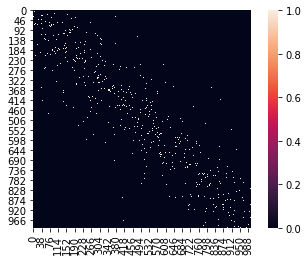

In [4]:
plot = sns.heatmap(y_ho_uni['net'], square=True)

Since we have ordered the nodes by their location in the Blau space, the homophily is immediately apparent on visualizing the adjacency matrix.

In [26]:
y_he_uni = generate_data(theta=2)

mean degree: 9.968


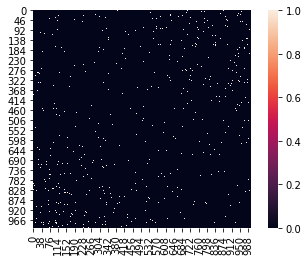

In [27]:
plot = sns.heatmap(y_he_uni['net'], square=True)

Now, a typical social survey might ask queries windowed around the respondent, such as "what proportion of your friends are within 2/5/10 years older or younger to you?" These questions allow the respondent to recall proportions rather simply, instead of asking say "what proportion of your friends are between 10 to 20 years old?" Let's write a function that gives us the mean value of this proportion from the population, corresponding to different windows $w$.

In [7]:
def query_friends(data, w, bootstrap=False, collapse=True):
    import numpy as np
    if not hasattr(w, '__iter__'): w = [w]
    x = data['x']
    w = [w_i*(max(x)-min(x)) for w_i in w]
    net = data['net']
    n = x.size
    w_prop = np.zeros([len(w), n])
    if bootstrap: idx = np.random.choice(n, n)
    else: idx = range(n)
    k = 0
    for i in idx:
        x_friends = x[net[i]]
        for j in range(len(w)):
            w_prop[j][k] = np.sum(np.abs(x_friends-x[i])<=w[j])/np.size(x_friends)
        k += 1
    if collapse: return np.nanmean(w_prop, axis=1)
    else: return w_prop, x[idx]

The above example of age can be continued here. Say age is uniformly distributed between 0 to 100, which leads to corresponding windows of 0.02, 0.05, 0.1, and thus we have:

In [8]:
windows = [0.02, 0.05, 0.1]
y_ho_uni_w = query_friends(y_ho_uni, windows)
y_he_uni_w = query_friends(y_he_uni, windows)

homophily props: [0.20018424 0.43497781 0.68405068]
heterophily props: [0.01795484 0.04790328 0.1017903 ]


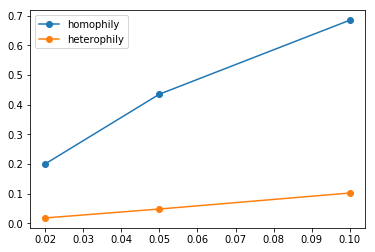

In [9]:
print('homophily props:', y_ho_uni_w)
print('heterophily props:', y_he_uni_w)
plt.plot(windows, y_ho_uni_w, marker='o', label='homophily')
plt.plot(windows, y_he_uni_w, marker='o', label='heterophily')
plt.legend()
plt.show()

The exponential acceleration for homophily is apparent, when compared to heterophily which is almost linear. Now using this as data, we can infer $\theta$.

In [10]:
def infer_theta(data, w):
    from scipy.optimize import curve_fit
    from numpy import arctan, arctanh, exp, sqrt, array
    
    def f_homophily(w, c): return (2*(exp(c*w)-1)/(c*sqrt(1-exp(c))))*arctanh(sqrt(1-exp(c))) #equation 24
    def f_heterophily(w, c): return (2*(exp(c*w)-1)/(c*sqrt(exp(c)-1)))*arctan(sqrt(exp(c)-1)) #equation 24
    def f_exponential(w, c): return ((exp(c*w/2)-1)/(3*(exp(c/2)-1)))*((exp(c*w/2)+1)/(exp(c/2)+1)+2) #equation 25
    
    if data['rate'] is not None:
        from scipy.stats import expon
        lambda_pred = 1.0/expon.fit(data['x'])[1]
        print('actual lambda:', data['rate'])
        print('predicted lambda:', lambda_pred)
    else: lambda_pred = None
        
    p = query_friends(data, w)
    theta_opt = {'+':None, '-':None}
    
    if lambda_pred is None:
        try:
            theta_opt['-'], d = curve_fit(f_homophily, w, p, bounds=(-float('inf'), 0))
        except:
            print ('homophily solution does not exist')
        try:
            theta_opt['+'], d = curve_fit(f_heterophily, w, p, bounds=(0, float('inf')))
        except:
            print ('heterophily solution does not exist')
    else:
        try:
            theta_opt['-'], d = curve_fit(f_exponential, lambda_pred*array(w), p, bounds=(-float('inf'), 0))
        except:
            print('homophily solution does not exist')
        try:
            theta_opt['+'], d = curve_fit(f_exponential, lambda_pred*array(w), p, bounds=(0, float('inf')))
        except:
            print('heterophily solution does not exist')
    return theta_opt

In [11]:
theta_ho_uni = infer_theta(y_ho_uni, w=[0.02, 0.05, 0.1])
print('inferred:', theta_ho_uni['-'][0], 'original:', y_ho_uni['theta'])

inferred: -9.258444749211646 original: -10


In [12]:
theta_he_uni = infer_theta(y_he_uni, w=[0.02, 0.05, 0.1])
print('inferred:', theta_he_uni['+'][0], 'original:', y_he_uni['theta'])

inferred: 2.081894393799176 original: 2


We obtain pretty good estimates for our parameters. Now we repeat the analysis for exponentially distributed population $X\sim\mathrm{Exp}(1/2)$, while keeping the same kernel parameters.

mean degree: 10.172
mean degree: 10.156


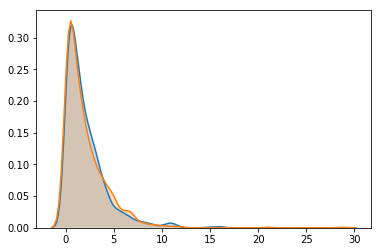

In [17]:
y_ho_exp = generate_data(theta=-10, rate=0.5)
y_he_exp = generate_data(theta=2, rate=0.5)

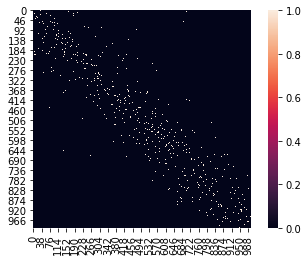

In [18]:
plot = sns.heatmap(y_ho_exp['net'], square=True)

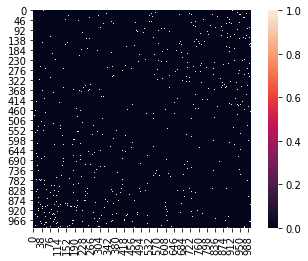

In [19]:
plot = sns.heatmap(y_he_exp['net'], square=True)

Note that the networks look almost identical to what we had earlier, which makes sense because the kernel is applied in $Y$, not $X$.

In [16]:
y_ho_exp_w = query_friends(y_ho_exp, windows)
y_he_exp_w = query_friends(y_he_exp, windows)

exponential props with homophily: [0.44426689 0.7091278  0.85798474]
exponential props with heterophily: [0.06269292 0.16937813 0.35423431]


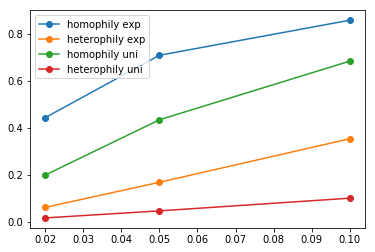

In [17]:
print('exponential props with homophily:', y_ho_exp_w)
plt.plot(windows, y_ho_exp_w, marker='o', label='homophily exp')
print('exponential props with heterophily:', y_he_exp_w)
plt.plot(windows, y_he_exp_w, marker='o', label='heterophily exp')
plt.plot(windows, y_ho_uni_w, marker='o', label='homophily uni')
plt.plot(windows, y_he_uni_w, marker='o', label='heterophily uni')
plt.legend()
plt.show()

Although the windows $w$ remain the same, we obtain a different response to the survey questions, due to the exponential distribution. Let us now infer $\theta$, using the approximate integral definition in equation 25 for small rate parameter $\lambda$.

In [18]:
theta_ho_exp = infer_theta(y_ho_exp, w=[0.02, 0.05, 0.1])
print('inferred:', theta_ho_exp['-'][0], 'original:', y_ho_exp['theta'])

actual lambda: 0.5
predicted lambda: 0.4779147685840821
inferred: -84.69889628623555 original: -10


In [19]:
theta_he_exp = infer_theta(y_he_exp, w=[0.02, 0.05, 0.1])
print('inferred:', theta_he_exp['+'][0], 'original:', y_he_exp['theta'])

actual lambda: 0.5
predicted lambda: 0.53642688173389
inferred: 5.056498105833083e-10 original: 2


We do not obtain close estimates to the original. This is possibly because the approximation that $w$ is small is not holding here when deriving the effective symmetric window. Below, we will see a general method which can be used for any arbitrary distribution using numerical integration.

Now, once we have inferred $\theta$, we can finally derive the categorical parameters $\rho_i$, which refers to the proportion of friends of people in community $i$ who are also in community $i$. Eventually, this is the crucial parameter, and $\theta$ is just used to get to it. As noted in the document, for both homophily and heterophly, a large number of communities $\kappa$ will give a "better" estimate of $\rho$. Correspondingly, let's see using equation 29, what these $\rho$s are if we divide the space into equiproportioned communities.

In [24]:
def query_rho(data, k=2, thetas=[]):
    if not isinstance(thetas, list): thetas = [thetas]
    import numpy as np
    k = int(k)
    x = data['x']
    net = data['net']
    communities = np.array_split(x, k)
    fig, ax = plt.subplots()
    for c in communities: plot = sns.distplot(c, kde=False, ax=ax)
    ax2 = ax.twinx()
    memberships = np.hstack([i*np.ones(communities[i].size, dtype=int) for i in range(k)])
    x_axis = [(c[0]+c[-1])/2 for c in communities]
    props = [list() for i in range(k)]
    n = x.size
    for i in range(n):
        m = memberships[i]
        props[m].append(np.sum(memberships[net[i]]==m)/np.sum(net[i]))
    props = [np.mean(p) for p in props]
    plt.plot(x_axis, props, marker='o', label='empirical')
    props_inferred = dict()
    for theta in thetas:
        props_inferred[theta] = list()
        factor = (np.exp(theta/(2*k))-1)*(np.exp(theta/(2*k))+5)/3 #equation 29
        for i in range(1, k+1):
            props_inferred[theta].append(factor/(np.exp(theta*((2*i-1)/(2*k)))+np.exp(theta*(1-(2*i-1)/(2*k)))-2))
        plt.plot(x_axis, props_inferred[theta], marker='o', label='theta '+'%.2f' % round(theta,2))
    plt.legend()
    plt.show()
    return np.sum(props), dict([(key, np.sum(val)) for (key, val) in props_inferred.items()])

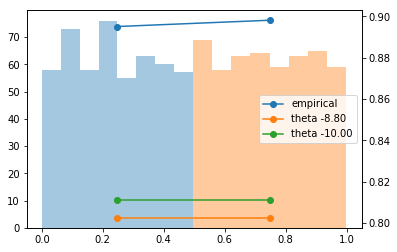

In [25]:
rho_ho_uni_2 = query_rho(y_ho_uni, thetas=[theta_ho_uni['-'][0], y_ho_uni['theta']], k=2)

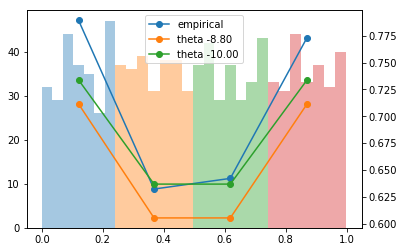

In [26]:
rho_ho_uni_4 = query_rho(y_ho_uni, thetas=[theta_ho_uni['-'][0], y_ho_uni['theta']], k=4)

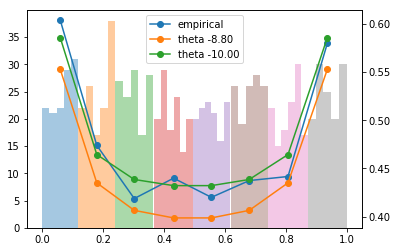

In [27]:
rho_ho_uni_8 = query_rho(y_ho_uni, thetas=[theta_ho_uni['-'][0], y_ho_uni['theta']], k=8)

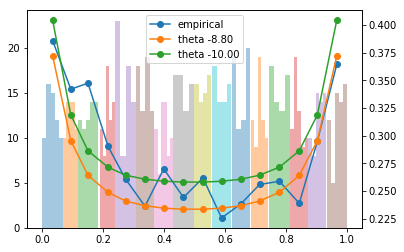

In [28]:
rho_ho_uni_16 = query_rho(y_ho_uni, thetas=[theta_ho_uni['-'][0], y_ho_uni['theta']], k=16)

The inferred parameter gives $\rho$s very close to the empirical estimate. Notice the edge effect, which leads to a U-shaped trend for homophily, and inverse-U-shaped trend for heterophily below.

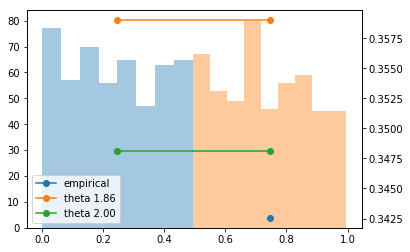

In [29]:
rho_he_uni_2 = query_rho(y_he_uni, thetas=[theta_he_uni['+'][0], y_he_uni['theta']], k=2)

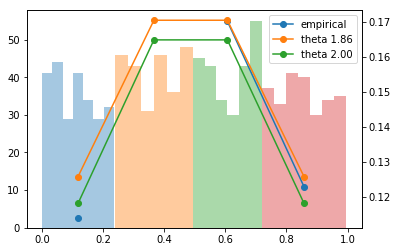

In [30]:
rho_he_uni_4 = query_rho(y_he_uni, thetas=[theta_he_uni['+'][0], y_he_uni['theta']], k=4)

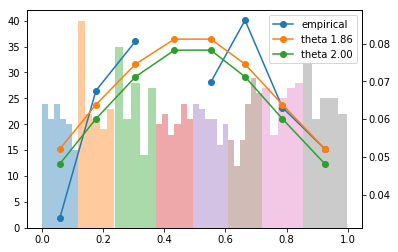

In [31]:
rho_he_uni_8 = query_rho(y_he_uni, thetas=[theta_he_uni['+'][0], y_he_uni['theta']], k=8)

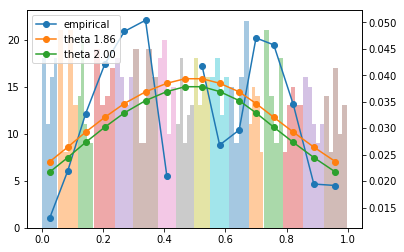

In [32]:
rho_he_uni_16 = query_rho(y_he_uni, thetas=[theta_he_uni['+'][0], y_he_uni['theta']], k=16)

We can do this analysis for exponentially distributed data as well.

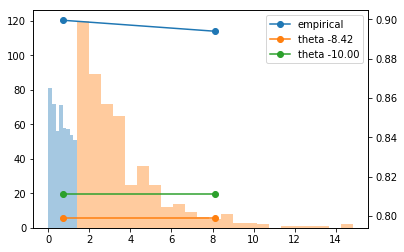

In [33]:
rho_ho_exp_2 = query_rho(y_ho_exp, thetas=[theta_ho_exp['-'][0], y_ho_exp['theta']], k=2)

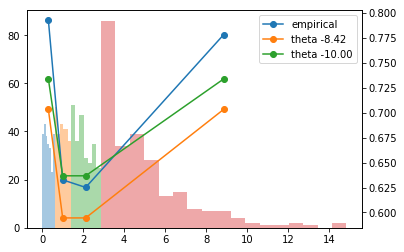

In [34]:
rho_ho_exp_4 = query_rho(y_ho_exp, thetas=[theta_ho_exp['-'][0], y_ho_exp['theta']], k=4)

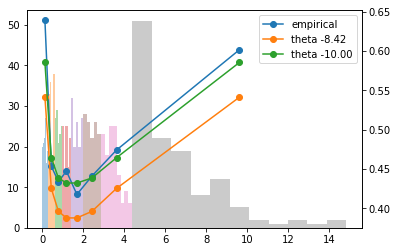

In [35]:
rho_ho_exp_8 = query_rho(y_ho_exp, thetas=[theta_ho_exp['-'][0], y_ho_exp['theta']], k=8)

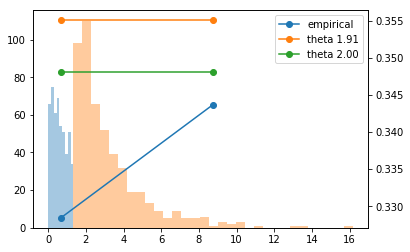

In [36]:
rho_he_exp_2 = query_rho(y_he_exp, thetas=[theta_he_exp['+'][0], y_he_exp['theta']], k=2)

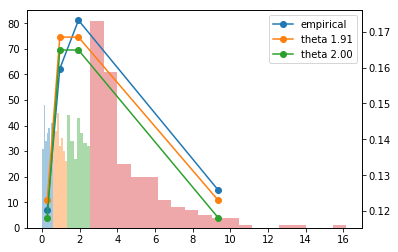

In [37]:
rho_he_exp_4 = query_rho(y_he_exp, thetas=[theta_he_exp['+'][0], y_he_exp['theta']], k=4)

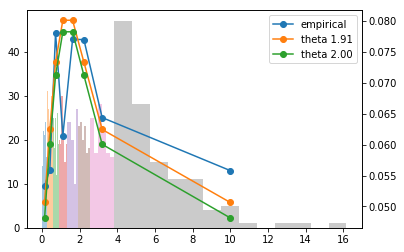

In [38]:
rho_he_exp_8 = query_rho(y_he_exp, thetas=[theta_he_exp['+'][0], y_he_exp['theta']], k=8)

## For Arbitrary Distributions

The above analysis was for uniform and exponential distributions. However, we can use numerical integration to approximate equation 17 and 23 for any arbitrary distribution in the Blau space. To do that, we first define a new class of random variables which "mimics" the empirical distribution of data. It does so by using a "[truncated](https://en.wikipedia.org/wiki/Truncated_distribution)" Gaussian KDE estimate in the support of the distribution, and thus its CDF can be defined appropriately

In [8]:
def mimic_distribution(data, gaussian_bw=None):
    from scipy import stats
    data = data.copy()
    data.sort()
    kernel = stats.gaussian_kde(data, gaussian_bw)
    norm = kernel.integrate_box_1d(data[0], data[-1])
    
    class kernel_distribution(stats.rv_continuous):
        def _pdf(self, x):
            if hasattr(x, '__iter__'):
                output = list()
                for x_i in x:
                    if data[0] <= x_i <= data[-1]: output.append(kernel.evaluate([[x_i]])[0]/norm)
                    else: output.append(0.0)
                return output
            else:
                if data[0] <= x <= data[-1]: return kernel.evaluate([[x]])[0]/norm
                else: return 0.0
        def _cdf(self, x):
            if hasattr(x, '__iter__'):
                output = list()
                for x_i in x:
                    if data[0] < x_i < data[-1]: output.append(kernel.integrate_box_1d(data[0], x_i)/norm)
                    elif x_i <= data[0]: output.append(0.0)
                    else: output.append(1.0)
                return output
            else:
                if data[0] < x < data[-1]: return kernel.integrate_box_1d(data[0], x)/norm
                elif x <= data[0]: return 0.0
                else: return 1.0
        def support(self):
            return (data[0], data[-1])
    
    return kernel_distribution(name='empirical_distribution')

Let us plot the learnt distribution for uniform and exponential cases mentioned above.

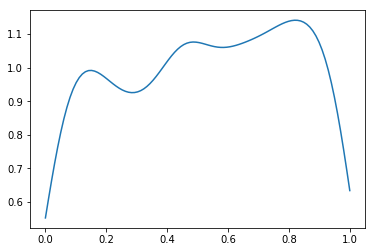

In [21]:
y_ho_uni_dist = mimic_distribution(y_ho_uni['x'])
support_uni = np.linspace(y_ho_uni_dist.support()[0], y_ho_uni_dist.support()[1], 100)
plt.plot(support_uni, y_ho_uni_dist.pdf(support_uni))
plt.show()

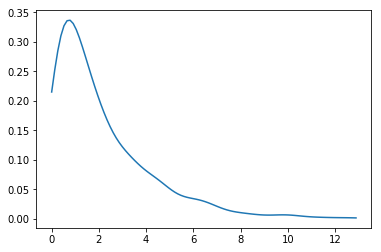

In [22]:
y_ho_exp_dist = mimic_distribution(y_ho_exp['x'])
support_exp = np.linspace(y_ho_exp_dist.support()[0], y_ho_exp_dist.support()[1], 100)
plt.plot(support_exp, y_ho_exp_dist.pdf(support_exp))
plt.show()

We can even generate samples from this empirical distribution.

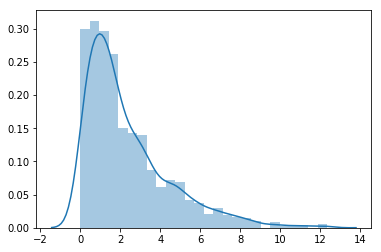

In [23]:
plot = sns.distplot(y_ho_exp_dist.rvs(size=1000))

Now we write a function that calculates the mean $\rho$, given a window $w$, for any arbitrary $\theta$. This is achieved by using numerical integration, to evaluate equations 17 and 23. 

In [24]:
def pfunc_given_w(data, w, intercept=0.0):
    x_dist = mimic_distribution(data['x'])
    x_a, x_b = x_dist.support()
    w *= (x_b-x_a)
    y_ll, y_ul = x_dist.cdf(x_a+w), x_dist.cdf(x_b-w)
    
    from numpy import exp
    import scipy.integrate as integrate
    
    # equation 17
    def f_lower(y, c):
        if c != 0: return (exp(c*y) + exp(c*(x_dist.cdf(x_dist.ppf(y)+w)-y)) - 2) / (exp(c*y) + exp(c*(1-y)) - 2)
        else: return x_dist.cdf(x_dist.ppf(y)+w)
    def f_middle(y, c):
        if c !=0: return (exp(c*(y-x_dist.cdf(x_dist.ppf(y)-w))) + exp(c*(x_dist.cdf(x_dist.ppf(y)+w)-y)) - 2) / (exp(c*y) + exp(c*(1-y)) - 2)
        else: return x_dist.cdf(x_dist.ppf(y)+w) - x_dist.cdf(x_dist.ppf(y)-w)
    def f_upper(y, c):
        if c != 0: return (exp(c*(y-x_dist.cdf(x_dist.ppf(y)-w))) + exp(c*(1-y)) - 2) / (exp(c*y) + exp(c*(1-y)) - 2)
        else: return 1 - x_dist.cdf(x_dist.ppf(y)-w)
    # equation 23
    if y_ll < y_ul:
        def f_integrated(c):
            return integrate.quad(f_lower, 0, y_ll, args=c)[0] + integrate.quad(f_middle, y_ll, y_ul, args=c)[0] + integrate.quad(f_upper, y_ul, 1, args=c)[0] + intercept
    else:
        def f_integrated(c):
            return integrate.quad(f_lower, 0, y_ul, args=c)[0] + (y_ll-y_ul) + integrate.quad(f_upper, y_ll, 1, args=c)[0] + intercept
    return f_integrated

Let us run this function for different values of $\theta$ corresponding to ambiphily, mild heterophily and mild homophily.

In [25]:
propfunc_uni = pfunc_given_w(y_ho_uni, w=0.05)
print(propfunc_uni(0), propfunc_uni(1), propfunc_uni(-1))

0.10005965771286945 0.07248025585960353 0.13234012457810632


In [26]:
propfunc_exp = pfunc_given_w(y_ho_exp, w=0.05)
print(propfunc_exp(0), propfunc_exp(1), propfunc_exp(-1))

0.2510682183032476 0.19520723148351937 0.31114752638743143


Now inferring $\theta$ becomes a simple root finding problem. Thus, we can infer it with even one window $w$.

In [27]:
def infer_theta_arb(data, w=0.01, bootstrap_samples=0, theta_min=-50.0, theta_max=50.0):
    if not hasattr(w, '__iter__'): w = [w]
    from scipy.optimize import brentq
    num_w = len(w)
    if bootstrap_samples==0: prop_emps = [query_friends(data, w)]
    else: prop_emps = [query_friends(data, w, bootstrap=True) for i in range(bootstrap_samples)]
    prop_funcs = [[pfunc_given_w(data, w[i], intercept=-prop_emps[j][i]) for j in range(len(prop_emps))] for i in range(num_w)]
    theta_opts = list()
    for prop_func in prop_funcs:
        theta_opt = list()
        for pf in prop_func:
            try: theta_opt.append(brentq(pf, theta_min, theta_max))
            except: theta_opt.append(None)
        theta_opts.append(theta_opt)
    return theta_opts

Let's infer $\theta$ for the homophily case, in both uniform and exponentially distributed scenarios, using the same windows $w=[0.02, 0.05, 0.1]$.

In [28]:
y_ho_uni_theta = infer_theta_arb(y_ho_uni, w=[0.02, 0.05, 0.1])
print(y_ho_uni_theta)

[[-9.72766406396968], [-9.899941487005789], [-9.92666186441379]]


In [29]:
y_ho_exp_theta = infer_theta_arb(y_ho_exp, w=[0.02, 0.05, 0.1])
print(y_ho_exp_theta)

[[-10.807852827307565], [-10.404572722873414], [-10.1514586040276]]


We get fairly good estimates of $\theta$, with all given values of the window, for both uniform and exponential distributions. We can repeat this for heterophily.

In [30]:
y_he_uni_theta = infer_theta_arb(y_he_uni, w=[0.02, 0.05, 0.1])
y_he_exp_theta = infer_theta_arb(y_he_exp, w=[0.02, 0.05, 0.1])
print(y_he_uni_theta, y_he_exp_theta)

[[2.24333581750684], [2.1518829980337517], [2.1023261940017886]] [[2.007728138517505], [1.9556627030249683], [1.8847779907689723]]


To do a more robust check of our algorithm, we can repeat the analysis across multiple values of $\theta$ and $w$ with multiple replicates of a generated network, for both uniform and exponentially distributed (or any other) dimensions. We perform a test on windows from $0.1$ to $0.9$, and homophily levels $-10$ to $+10$, with 3 replicates per $\theta$, for uniformly distributed and exponentially distributed dimensions: $\lambda=0.5, 2$.

In [31]:
def theta_testing(rate=None, thetas=None, windows=None, num_reps=3):
    import numpy as np
    if thetas is None: thetas = np.linspace(-10, 10, 11) #np.concatenate([np.linspace(-40, -20, 3), np.linspace(-10, 10, 11), np.linspace(20, 40, 3)])
    if not hasattr(thetas, '__iter__'): thetas = [thetas]
    if windows is None: windows = np.linspace(0.1, 0.9, 5) #np.concatenate([[0.01, 0.02, 0.05], np.linspace(0.1, 0.9, 5), [0.95, 0.98, 0.99]])
    if not hasattr(windows, '__iter__'): windows = [windows]
    thetas_opt = list()
    print('trying', num_reps, 'rep(s) per theta, for windows', windows)
    for theta in thetas:
        theta_opt = list()
        for i in range(num_reps):
            print('theta', theta, 'rep', i+1)
            data_curr = generate_data(theta=theta, rate=rate)  
            theta_opt.append(np.array(infer_theta_arb(data_curr, windows), dtype=float).flatten())
            print('inferred theta', theta_opt[-1])
        thetas_opt.append(np.vstack(theta_opt))
    return {'original':thetas, 'inferred': np.dstack(thetas_opt), 'windows':windows, 'rate':rate}

In [8]:
theta_test_uni = theta_testing()

trying 3 rep(s) per theta, for windows [0.1 0.3 0.5 0.7 0.9]
theta -10.0 rep 1
mean degree: 10.056
inferred theta [ -9.59939587  -9.31694277  -9.52861009  -8.0547647  -50.        ]
theta -10.0 rep 2
mean degree: 9.84
inferred theta [ -9.48677354  -9.42203705 -10.22308624  -9.51067712 -50.        ]
theta -10.0 rep 3
mean degree: 9.97
inferred theta [ -9.57245715  -9.93161801 -11.22691586  -8.71194828 -50.        ]
theta -8.0 rep 1
mean degree: 10.262
inferred theta [ -7.41945392  -6.94764944  -7.42871641  -7.76803058 -50.        ]
theta -8.0 rep 2
mean degree: 10.164
inferred theta [ -7.44938702  -7.41357945  -7.23078832  -6.4800141  -50.        ]
theta -8.0 rep 3
mean degree: 9.678
inferred theta [ -7.58032563  -7.48962256  -7.75469073  -6.88318869 -50.        ]
theta -6.0 rep 1
mean degree: 10.202
inferred theta [ -5.57539005  -5.31291371  -5.40536053  -5.35942402 -50.        ]
theta -6.0 rep 2
mean degree: 9.722
inferred theta [-6.26410358 -5.95878363 -6.1078684  -5.3289928  -4.04610

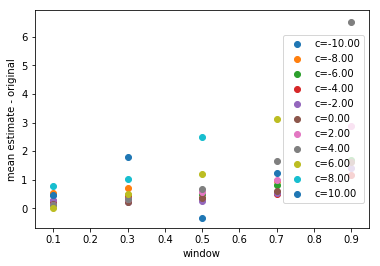

In [35]:
theta_test_uni['inferred'][theta_test_uni['inferred']<=-12] = np.nan
theta_test_uni['inferred'][theta_test_uni['inferred']>=12] = np.nan
for i in range(len(theta_test_uni['original'])):
    plt.scatter(theta_test_uni['windows'], np.nanmean(theta_test_uni['inferred'][:,:,i], axis=0)-theta_test_uni['original'][i], marker='o', label='c='+'%.2f' % round(theta_test_uni['original'][i],2))
plt.legend(loc='right')
plt.xlabel('window')
plt.ylabel('mean estimate - original')
plt.show()

Therefore we note that inference of $\theta$ is overall best when we consider a small $w$, even for very heterophilous kernels. This might seem surprising at first, but there's just more signal of $\theta$ in $p$ for small values of $w$, as noted in the integral in the function `pfunc_given_w()`. Thus in our surveys, we must ensure a window $w$ which is as small as possible.

trying 3 rep(s) per theta, for windows [0.1 0.3 0.5 0.7 0.9]
theta -10.0 rep 1
mean degree: 9.964
inferred theta [ -9.80170623  -9.96746936  -9.66195019  -6.18828867 -50.        ]
theta -10.0 rep 2
mean degree: 10.046
inferred theta [-10.675991607208202 -8.38338509736941 -8.663667136572167
 -3.6768566677558594 None]
theta -10.0 rep 3
mean degree: 9.578
inferred theta [ -9.77475641  -9.78450558  -7.75283333  -4.97881804 -50.        ]
theta -8.0 rep 1
mean degree: 9.748
inferred theta [-8.145921583965393 -6.951807502800489 -5.6944558041424065
 -5.395176681575695 None]
theta -8.0 rep 2
mean degree: 10.046
inferred theta [-8.13991764 -7.17649    -1.40809691  1.64796124 -3.02893977]
theta -8.0 rep 3
mean degree: 9.826
inferred theta [-8.40633285010461 -7.041534370330395 -5.735104660387705
 -5.223508196901433 None]
theta -6.0 rep 1
mean degree: 9.756
inferred theta [-6.130319897439739 -6.071048301106438 -6.4652018440612435
 -4.7987337394747085 None]
theta -6.0 rep 2
mean degree: 9.8
inferred

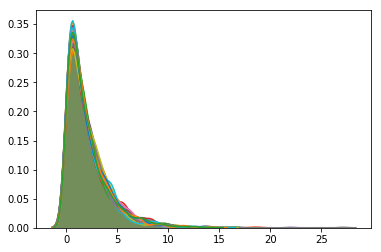

In [36]:
theta_test_exp_half = theta_testing(rate=0.5)

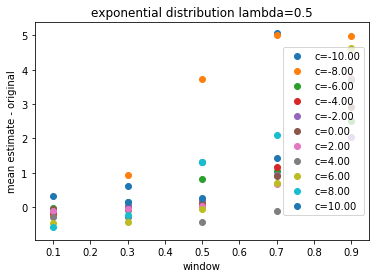

In [44]:
theta_test_exp_half['inferred'][theta_test_exp_half['inferred']<=-12] = np.nan
theta_test_exp_half['inferred'][theta_test_exp_half['inferred']>=12] = np.nan
for i in range(len(theta_test_exp_half['original'])):
    plt.scatter(theta_test_exp_half['windows'], np.nanmean(theta_test_exp_half['inferred'][:,:,i], axis=0)-theta_test_exp_half['original'][i], marker='o', label='c='+'%.2f' % round(theta_test_exp_half['original'][i],2))
plt.legend(loc='right')
plt.xlabel('window')
plt.ylabel('mean estimate - original')
plt.title('exponential distribution lambda=0.5')
plt.show()

trying 3 rep(s) per theta, for windows [0.1 0.3 0.5 0.7 0.9]
theta -10.0 rep 1
mean degree: 9.844
inferred theta [ -9.70184384  -9.39345325  -8.80717145  -8.24934144 -50.        ]
theta -10.0 rep 2
mean degree: 10.002
inferred theta [-10.402851000982503 -8.347708072012498 -6.74111498698898
 -14.413182221654848 None]
theta -10.0 rep 3
mean degree: 10.266
inferred theta [ -9.42319016  -8.68518436  -8.05868225  -6.71167096 -50.        ]
theta -8.0 rep 1
mean degree: 9.728
inferred theta [ -8.49933367  -8.36533638  -6.59775815  -6.65622764 -50.        ]
theta -8.0 rep 2
mean degree: 9.944
inferred theta [ -7.827533    -7.31891242  -6.83671151  -8.12448924 -50.        ]
theta -8.0 rep 3
mean degree: 9.912
inferred theta [ -8.56129385  -7.33368716  -7.00180157  -8.87058827 -50.        ]
theta -6.0 rep 1
mean degree: 9.884
inferred theta [-5.752804186998545 -4.9086355114327125 -4.646889512431385
 -9.915707232205007 None]
theta -6.0 rep 2
mean degree: 10.174
inferred theta [-5.723020165110313 

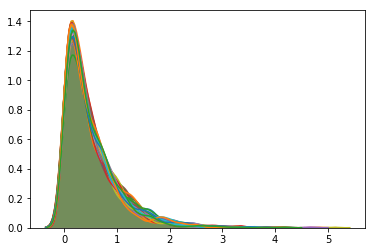

In [45]:
theta_test_exp_two = theta_testing(rate=2)

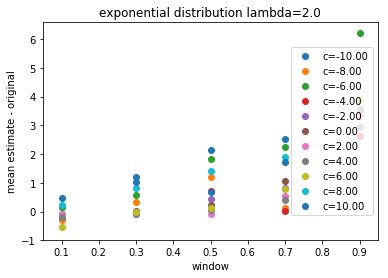

In [49]:
theta_test_exp_two['inferred'][theta_test_exp_two['inferred']<=-12] = np.nan
theta_test_exp_two['inferred'][theta_test_exp_two['inferred']>=12] = np.nan
for i in range(len(theta_test_exp_two['original'])):
    plt.scatter(theta_test_exp_two['windows'], np.nanmean(theta_test_exp_two['inferred'][:,:,i], axis=0)-theta_test_exp_two['original'][i], marker='o', label='c='+'%.2f' % round(theta_test_exp_two['original'][i],2))
plt.legend(loc='right')
plt.xlabel('window')
plt.ylabel('mean estimate - original')
plt.title('exponential distribution lambda=2.0')
plt.show()

## Getting "Posteriors" on $\theta$ 

### Bootstrap Principle

From the above analysis, we can confidently say that we must query at a small window in our social survey. Furthermore, to be more confident in our estimate of $\theta$, we can use the [bootstrap principle](https://math.mit.edu/~dav/05.dir/class24-prep-a.pdf). to obtain a "posterior" of $\theta$, and confidence intervals given some significance level.

If $\theta$ is the parameter to be inferred, and $\hat\theta$ is the estimator, then we can obtain confidence intervals on $\hat\theta$ by obtaining the bootstrap distribution of $\hat\theta$. We use the [percentile bootstrap](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)) method to generate bounds from the bootstrap distribution.

Let us demonstrate for $\theta=-10$, with 20 bootstrap samples, and a 80% confidence interval ($\alpha=0.1$).

In [117]:
def theta_bootstrap(theta=-10, window=0.05, rate=None, bootstrap_samples=20, alpha=0.1):
    import numpy as np
    data = generate_data(theta=theta, rate=rate) 
    theta_mean = infer_theta_arb(data, window)[0][0]
    print('inferred theta mean', theta_mean)
    theta_boot = np.array(infer_theta_arb(data, window, bootstrap_samples), dtype=float)
    theta_boot = theta_boot[~np.isnan(theta_boot)]
    theta_boot.sort()
    dist = sns.kdeplot(theta_boot, shade=True)
    if alpha is not None:
        idx = int(alpha*theta_boot.size)
        theta_lb, theta_ub = theta_boot[idx-1], theta_boot[theta_boot.size-idx]
        print('theta lb', theta_lb, 'theta ub', theta_ub)
    else: theta_lb, theta_ub = None, None
    return {'theta_original':theta, 
            'theta_mean':theta_mean,
            'theta_boot':theta_boot,
            'theta_lb':theta_lb,
            'theta_ub':theta_ub,
            'alpha':alpha,
            'window':window,
            'rate':rate,
            'num_samples':bootstrap_samples}

mean degree: 9.95
inferred theta mean -9.78409303348215
theta lb -10.062247621878598 theta_ub -9.555359303443563


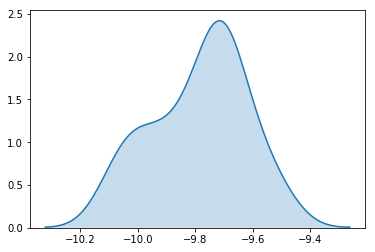

In [112]:
theta_ho_posterior = theta_bootstrap(theta=-10)

In [116]:
print('estimator theta', theta_ho_posterior['theta_mean'])
print('mean of bootstrap distribution', theta_ho_posterior['theta_boot'].mean())

estimator theta -9.78409303348215
mean of bootstrap distribution -9.786180104104698


We obtain a fairly tight bound on our estimate. (Moreover, the mean of the bootstrap distribution is in close agreement with the estimator $\hat\theta$.) We see the same if the Blau space is exponentially distributed, although the bias in the mean of bootstrap distribution seems to have increased.

mean degree: 10.024
inferred theta mean -9.882136545814932
theta lb -10.63878527691522 theta_ub -9.259503042851989


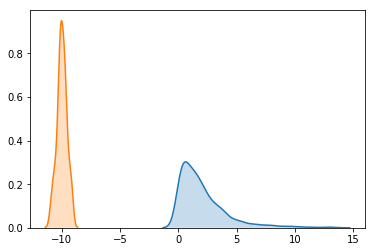

In [115]:
theta_ho_exp_posterior = theta_bootstrap(theta=-10, rate=0.5)

In [118]:
print('estimator theta', theta_ho_exp_posterior['theta_mean'])
print('mean of bootstrap distribution', theta_ho_exp_posterior['theta_boot'].mean())

estimator theta -9.882136545814932
mean of bootstrap distribution -9.981175116710483


Now looking at heterophily, mild levels seem to maintain a tight bound, while a strong level of homophily is grossly mis-estimated with a loose bound.

mean degree: 9.736
inferred theta mean 5.043180157237976
theta lb 4.661190159357731 theta ub 5.387162254634897


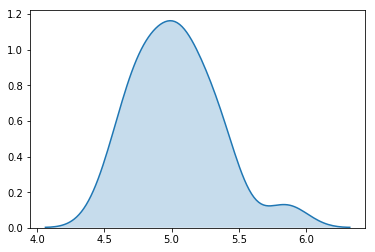

In [122]:
theta_he_posterior = theta_bootstrap(theta=5)

In [123]:
print('estimator theta', theta_he_posterior['theta_mean'])
print('mean of bootstrap distribution', theta_he_posterior['theta_boot'].mean())

estimator theta 5.043180157237976
mean of bootstrap distribution 5.031942431799566


mean degree: 10.206
inferred theta mean 15.985553490278152
theta lb 14.41250788069364 theta ub 17.664302814191494


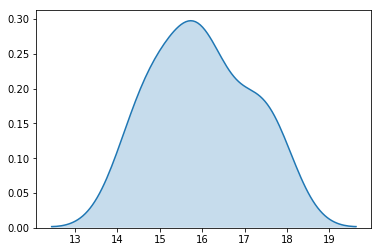

In [124]:
theta_he_posterior_extreme = theta_bootstrap(theta=10)

In [125]:
print('estimator theta', theta_he_posterior_extreme['theta_mean'])
print('mean of bootstrap distribution', theta_he_posterior_extreme['theta_boot'].mean())

estimator theta 15.985553490278152
mean of bootstrap distribution 15.978595655286991


Let's retry with a slightly larger window $w=0.1$, which we hope will better recovery a strongly heterophilous kernel.

mean degree: 9.792
inferred theta mean 9.297291071309619
theta lb 8.424165879654026 theta ub 11.6817636280219


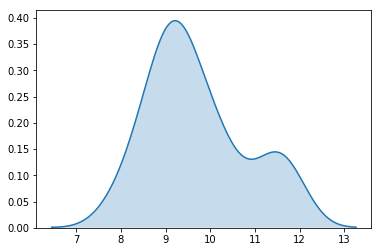

In [126]:
theta_he_posterior_extreme_wide = theta_bootstrap(theta=10, window=0.1)

In [127]:
print('estimator theta', theta_he_posterior_extreme_wide['theta_mean'])
print('mean of bootstrap distribution', theta_he_posterior_extreme_wide['theta_boot'].mean())

estimator theta 9.297291071309619
mean of bootstrap distribution 9.697990988018969


This time, we obtain a better estimate of $\theta$ with tighter bounds than before. Ideally for real survey data, we should ask for at least 2 windows, while bootstrapping for a large number of samples (say 100-200) and with a larger confidence interval like 95%, to be more confident about these bounds.

### Gaussian Process Regression

Another way to obtain posteriors on $\theta$ is to assume a GP prior on it. Say $\theta$ is defined by:

$$\theta \sim \mathcal{GP}(0, k(y,y'))$$

Where $k$ is the covariance function, whose corresponding covariance matrix can be written as $K$:

$$k(y,y') = c*\exp\left(-\frac{1}{2}\left(\frac{y-y'}{\gamma}\right)^2\right) + \epsilon$$
$$[K(y,y)]_{ij} = k(y_i,y_j)$$

where $\epsilon\sim\mathcal{N}(0,\sigma^2)$. Then we can estimate $\theta$ separately for all data-points $y_i=F_X(x_i)$, and then fit parameters of the kernel using MLE. More precisely, let $y, \theta$ be the vector of observed positions in the Blau space and corresponding (inferred) homophilies ("training data") and $y^*$ be the vector of unobserved positions (testing data), and $\phi = \{c,\gamma,\sigma\}$ the parameters of kernel (covariance function) $k(y,y')$. Then we can write the distribution of $\theta$, the vector of homophilies of observed positions as:

$$\theta \sim \mathcal{N}(0, K(y,y))$$

$$\implies \log(P(\theta|y,\phi)) = -\frac{1}{2}\theta^TK(y,y)^{-1}\theta -\frac{1}{2}\log\det(K(y,y)) -\frac{n}{2}\log 2\pi$$

Once $\phi$ is inferred, we can write the posterior predictive distribution of $\theta^*$, the vector of homophilies for unobserved positions, as:

$$ \theta^*|y^*,y,\theta,\phi \sim \mathcal{N}\left(K(y^*,y)K(y,y)^{-1}\theta, K(y^*, y^*) - K(y^*,y)K(y,y)^{-1}K(y^*,y)^T\right)$$

Let us execute this in code. First, we write a new function that gives us proportion of friends given a window $w$ and data-point $y_i$. Note that we no longer have to perform an integration, an simply need equation 17. In essence, we are replacing integration at the data level to marginalization in the GP.

In [9]:
def pfunc_given_w_x(data, w):
    x_dist = mimic_distribution(data['x'])
    x_a, x_b = x_dist.support()
    w *= (x_b-x_a)
    y = x_dist.cdf(data['x'])
    y_ll, y_ul = x_dist.cdf(x_a+w), x_dist.cdf(x_b-w)
    
    from numpy import exp
    
    # equation 17
    def f_lower(c, y, i):
        if c != 0: return (exp(c*y) + exp(c*(x_dist.cdf(x_dist.ppf(y)+w)-y)) - 2) / (exp(c*y) + exp(c*(1-y)) - 2) + i
        else: return x_dist.cdf(x_dist.ppf(y)+w) + i
    def f_middle(c, y, i):
        if c !=0: return (exp(c*(y-x_dist.cdf(x_dist.ppf(y)-w))) + exp(c*(x_dist.cdf(x_dist.ppf(y)+w)-y)) - 2) / (exp(c*y) + exp(c*(1-y)) - 2) + i
        else: return x_dist.cdf(x_dist.ppf(y)+w) - x_dist.cdf(x_dist.ppf(y)-w) + i
    def f_upper(c, y, i):
        if c != 0: return (exp(c*(y-x_dist.cdf(x_dist.ppf(y)-w))) + exp(c*(1-y)) - 2) / (exp(c*y) + exp(c*(1-y)) - 2) + i
        else: return 1 - x_dist.cdf(x_dist.ppf(y)-w) + i
    
    funcs = list()
    if y_ul>y_ll:
        for y_i in y:
            if y_i<=y_ll: funcs.append(f_lower)
            elif y_i>=y_ul: funcs.append(f_upper)
            else: funcs.append(f_middle)
    else:
        for y_i in y:
            if y_i<=y_ul: funcs.append(f_lower)
            elif y_i>=y_ll: funcs.append(f_upper)
            else: funcs.append(lambda c, y, i: 1.0 + i)
    return y, funcs

In [13]:
def infer_theta_gpr(data, w=0.1, kernel=True, theta_min=-50.0, theta_max=50.0, verbose=False):
    from scipy.optimize import brentq
    import numpy as np
    prop_emps, x = query_friends(data, w, collapse=False)
    prop_emps = prop_emps.flatten()
    y, prop_funcs = pfunc_given_w_x(data, w)
    y = y[~np.isnan(prop_emps)]
    prop_funcs = np.array(prop_funcs)
    prop_funcs = prop_funcs[~np.isnan(prop_emps)]
    prop_emps = prop_emps[~np.isnan(prop_emps)]
    theta_opts = list()
    for i in range(len(y)):
        if verbose and i%100==0: print('inferring theta for datapoint', i+1)
        try: theta_opts.append(brentq(prop_funcs[i], theta_min, theta_max, args=(y[i], -prop_emps[i])))
        except: theta_opts.append(None)
    theta_opts = np.array(theta_opts, dtype=float)
    theta_opts[theta_opts==theta_min] = np.nan
    theta_opts[theta_opts==theta_max] = np.nan
    y = y[~np.isnan(theta_opts)]
    theta_opts = theta_opts[~np.isnan(theta_opts)]
    
    from sklearn.gaussian_process import GaussianProcessRegressor
    from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel as WGN
    if kernel: kernel = C(1.0)*RBF(1.0) + WGN(1.0)
    else: kernel = C(1.0) + WGN(1.0)
    gp = GaussianProcessRegressor(kernel=kernel, alpha=0.0, n_restarts_optimizer=9)
    gp.fit(y.reshape(-1,1), theta_opts)    
    y_support = np.linspace(0,1,100).reshape(-1,1)
    theta_pred, sigma = gp.predict(y_support, return_std=True)
    plt.plot(y, theta_opts, 'r.', markersize=10, label='conditional estimates')
    plt.plot(y_support, theta_pred, 'b-', label='mean theta')
    plt.fill(np.concatenate([y_support, y_support[::-1]]), np.concatenate([theta_pred - 1.9600*sigma, (theta_pred + 1.9600*sigma)[::-1]]),
             alpha=.5, fc='b', ec='None', label='95% confidence interval')
    plt.xlabel('$y=F_X(x)$')
    plt.ylabel('$theta(y)$')
    plt.legend(loc='lower left')
    return {'gp':gp, 'y':y, 'theta_y':theta_opts, 'theta_mean':np.mean(theta_pred)}    

Taking the example of $\theta=-10$ for uniform distribution, we obtain a mean estimate of $\theta$ close to the original. That is, despite gaining extra degrees of freedom in the sense that $\theta$ need not be the same everywhere, the mean estimate assuming a smooth trend with the Blau space has led to the same conclusion of having a uniform $\theta$. However, the confidence intervals are not tight as they were in the bootstrap scenario. Plotting the actual data, and looking at the inferred GP-kernel parameters, we can see that the noise variance is quite high and individual best-estimates of $\theta$ are wildly varying on either side of $-10$.

9.21**2 * RBF(length_scale=0.2) + WhiteKernel(noise_level=19.4)
theta mean -9.72629489647006


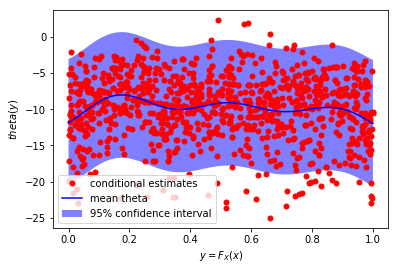

In [11]:
theta_ho_uni_gp = infer_theta_gpr(y_ho_uni)
print(theta_ho_uni_gp['gp'].kernel_)
print('theta mean', theta_ho_uni_gp['theta_mean'])

Since the lengthscale is quite large, it also makes sense to compare the RBF-kernel GP to just a Normal distribution prior on $\theta$, which would correspond to just using a ``WhiteKernel``.

9.77**2 + WhiteKernel(noise_level=20.1)
theta mean -9.77154190884653


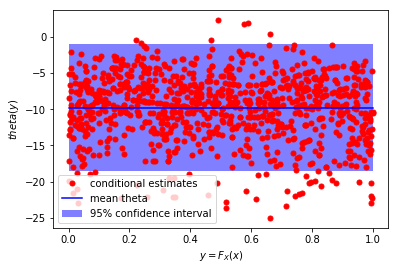

In [14]:
theta_ho_uni_normal = infer_theta_gpr(y_ho_uni, kernel=False)
print(theta_ho_uni_normal['gp'].kernel_)
print('theta mean', theta_ho_uni_normal['theta_mean'])

For mild heterophily when $\theta=2$, we obtain a lower noise level, however the mean estimate of $\theta$ is far from the original. Interestingly, an edge-effect is noticeable in the variance in the middle of the distribution.

0.777**2 * RBF(length_scale=0.223) + WhiteKernel(noise_level=3.24)
theta mean 0.8451099026275253


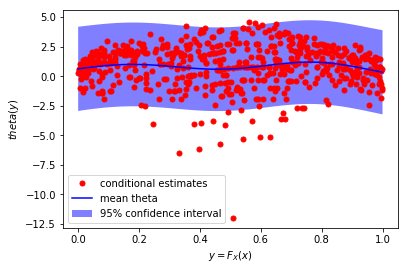

In [15]:
theta_he_uni_gp = infer_theta_gpr(y_he_uni)
print(theta_he_uni_gp['gp'].kernel_)
print('theta mean', theta_he_uni_gp['theta_mean'])

0.843**2 + WhiteKernel(noise_level=3.29)
theta mean 0.8392174562508751


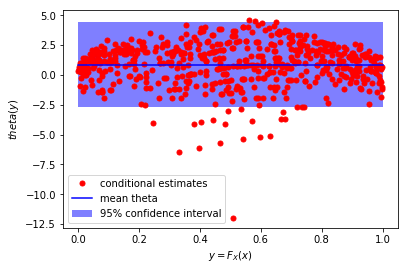

In [16]:
theta_he_uni_normal = infer_theta_gpr(y_he_uni, kernel=False)
print(theta_he_uni_normal['gp'].kernel_)
print('theta mean', theta_he_uni_normal['theta_mean'])

Even after assuming a Normal prior the estimate isn't close to the original $\theta$. We can repeat the analysis for exponentially distributed Blau space. For $\theta=-10$, we obtain a mean estimate of around $-7$, and the estimate has a downward trend with $y$. That is, the sparsely populated seem to be experiencing more homophily than those in a crowdly populated region of the Blau space. This satisfies our intuition about an exponentially distributed Blau space.

13.1**2 * RBF(length_scale=0.82) + WhiteKernel(noise_level=19)
theta mean -6.1544418056805


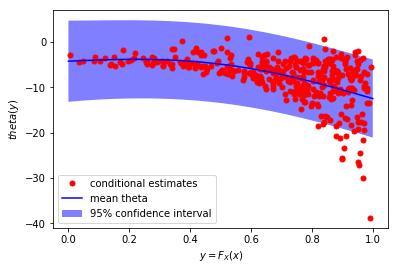

In [20]:
theta_ho_exp_gp = infer_theta_gpr(y_ho_exp)
print(theta_ho_exp_gp['gp'].kernel_)
print('theta mean', theta_ho_exp_gp['theta_mean'])

7.8**2 + WhiteKernel(noise_level=25.6)
theta mean -7.794177651677419


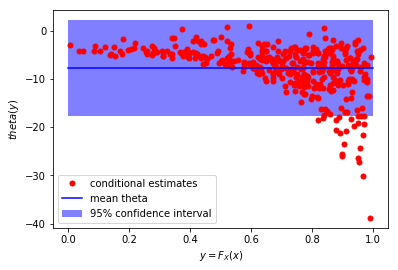

In [21]:
theta_ho_exp_normal = infer_theta_gpr(y_ho_exp, kernel=False)
print(theta_ho_exp_normal['gp'].kernel_)
print('theta mean', theta_ho_exp_normal['theta_mean'])

For mild heterophily, we see an upward trend of $\theta$ with $y$, particularly in the middle. 

3.79**2 * RBF(length_scale=0.123) + WhiteKernel(noise_level=6.07)
theta mean 3.2635619976972534


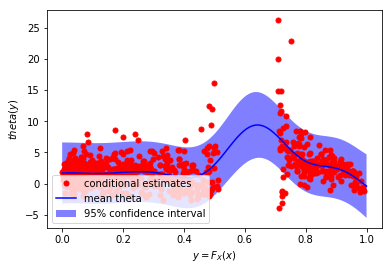

In [22]:
theta_he_exp_gp = infer_theta_gpr(y_he_exp)
print(theta_he_exp_gp['gp'].kernel_)
print('theta mean', theta_he_exp_gp['theta_mean'])

2.21**2 + WhiteKernel(noise_level=7.72)
theta mean 2.203289511616656


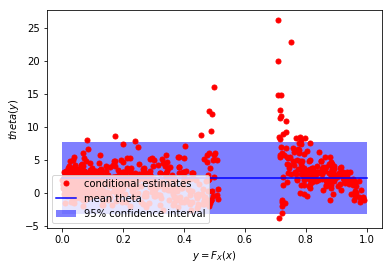

In [23]:
theta_he_exp_normal = infer_theta_gpr(y_he_exp, kernel=False)
print(theta_he_exp_normal['gp'].kernel_)
print('theta mean', theta_he_exp_normal['theta_mean'])

In this case, we do notice a better mean estimate of $\theta$. It seems that the unexpected kinks with RBF kernel due to the edge effects of the distribution. To verify, we generate ambiphilous data in both uniform and exponentially distributed settings.

In [49]:
y_ambi_uni = generate_data()

mean degree: 10.01


mean degree: 10.132


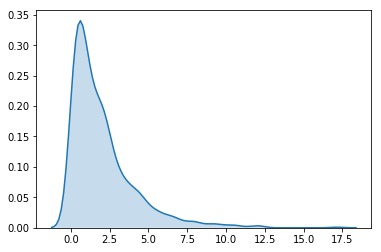

In [45]:
y_ambi_exp = generate_data(rate=0.5)

0.776**2 * RBF(length_scale=0.0948) + WhiteKernel(noise_level=5.25)
theta mean -0.43384587709938216


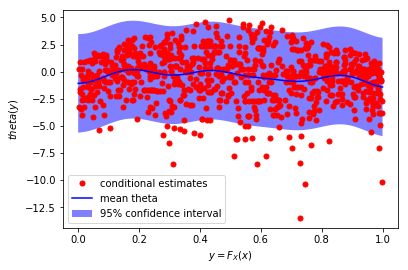

In [50]:
theta_ambi_uni_gp = infer_theta_gpr(y_ambi_uni)
print(theta_ambi_uni_gp['gp'].kernel_)
print('theta mean', theta_ambi_uni_gp['theta_mean'])

2.4**2 * RBF(length_scale=0.0355) + WhiteKernel(noise_level=8.26)
theta mean -0.18457014982818273


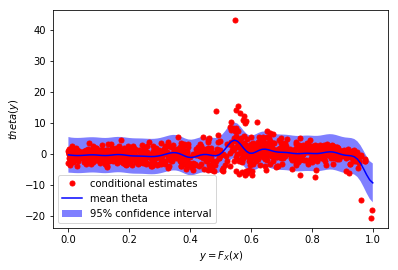

In [46]:
theta_ambi_exp_gp = infer_theta_gpr(y_ambi_exp)
print(theta_ambi_exp_gp['gp'].kernel_)
print('theta mean', theta_ambi_exp_gp['theta_mean'])

In conclusion, using this GP setup allows us to not assume the same $\theta$ for all points in the Blau sapce, which offers more degrees of freedom in inference. However, this lower resolution estimate may not induce huge gains unless there is a compelling reason to believe that $\theta$ should vary. The robustness of mathematically integrating over $y$ encourages assuming the same $\theta$ for all $y$.